# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_nopercolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['block_16_expand', 'lock_16_project', 'block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8386 - accuracy: 0.7250

947/947 [==============================] - 3727s 4s/step - loss: 0.8386 - accuracy: 0.7250 - val_loss: 4.2250 - val_accuracy: 0.6242
Epoch 2/200
947/947 [==============================] - 3261s 3s/step - loss: 0.7352 - accuracy: 0.7481 - val_loss: 6.2766 - val_accuracy: 0.6632
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.7666

947/947 [==============================] - 3460s 4s/step - loss: 0.6809 - accuracy: 0.7666 - val_loss: 2.7954 - val_accuracy: 0.6534
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.7758

947/947 [==============================] - 3481s 4s/step - loss: 0.6472 - accuracy: 0.7758 - val_loss: 2.3980 - val_accuracy: 0.3475
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6285 - accuracy: 0.7807

947/947 [==============================] - 3469s 4s/step - loss: 0.6285 - accuracy: 0.7807 - val_loss: 1.6117 - val_accuracy: 0.6377
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.7885

947/947 [==============================] - 3465s 4s/step - loss: 0.6015 - accuracy: 0.7885 - val_loss: 1.3327 - val_accuracy: 0.6274
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5861 - accuracy: 0.7923

947/947 [==============================] - 3450s 4s/step - loss: 0.5861 - accuracy: 0.7923 - val_loss: 0.9271 - val_accuracy: 0.7189
Epoch 8/200
947/947 [==============================] - 3263s 3s/step - loss: 0.5726 - accuracy: 0.7983 - val_loss: 1.7252 - val_accuracy: 0.5450
Epoch 9/200
947/947 [==============================] - 3249s 3s/step - loss: 0.5538 - accuracy: 0.8047 - val_loss: 3.2093 - val_accuracy: 0.6542
Epoch 10/200
947/947 [==============================] - 3261s 3s/step - loss: 0.5470 - accuracy: 0.8050 - val_loss: 0.9493 - val_accuracy: 0.7218
Epoch 11/200
947/947 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.8106

947/947 [==============================] - 3457s 4s/step - loss: 0.5383 - accuracy: 0.8106 - val_loss: 0.8716 - val_accuracy: 0.7337
Epoch 12/200
947/947 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.8160

947/947 [==============================] - 3456s 4s/step - loss: 0.5236 - accuracy: 0.8160 - val_loss: 0.7015 - val_accuracy: 0.7785
Epoch 13/200
947/947 [==============================] - 3254s 3s/step - loss: 0.5161 - accuracy: 0.8162 - val_loss: 1.6200 - val_accuracy: 0.7073
Epoch 14/200
947/947 [==============================] - 3270s 3s/step - loss: 0.5020 - accuracy: 0.8225 - val_loss: 0.8875 - val_accuracy: 0.7300
Epoch 15/200
947/947 [==============================] - 3255s 3s/step - loss: 0.4933 - accuracy: 0.8238 - val_loss: 1.2704 - val_accuracy: 0.7386
Epoch 16/200
947/947 [==============================] - 3249s 3s/step - loss: 0.4840 - accuracy: 0.8289 - val_loss: 0.9540 - val_accuracy: 0.7370
Epoch 17/200
947/947 [==============================] - 3275s 3s/step - loss: 0.4823 - accuracy: 0.8250 - val_loss: 0.7069 - val_accuracy: 0.7583
Epoch 18/200
947/947 [==============================] - 3255s 3s/step - loss: 0.4716 - accuracy: 0.8338 - val_loss: 0.9168 - val_accuracy

947/947 [==============================] - 3889s 4s/step - loss: 0.4124 - accuracy: 0.8524 - val_loss: 0.6722 - val_accuracy: 0.7798
Epoch 27/200
947/947 [==============================] - 3749s 4s/step - loss: 0.4120 - accuracy: 0.8525 - val_loss: 0.7231 - val_accuracy: 0.7827
Epoch 28/200
947/947 [==============================] - 3713s 4s/step - loss: 0.4032 - accuracy: 0.8555 - val_loss: 0.6933 - val_accuracy: 0.7794
Epoch 29/200
947/947 [==============================] - 3507s 4s/step - loss: 0.4019 - accuracy: 0.8545 - val_loss: 1.0217 - val_accuracy: 0.6694
Epoch 30/200
947/947 [==============================] - 3360s 4s/step - loss: 0.3893 - accuracy: 0.8602 - val_loss: 0.8876 - val_accuracy: 0.7390
Epoch 31/200
947/947 [==============================] - 3279s 3s/step - loss: 0.3846 - accuracy: 0.8615 - val_loss: 0.7083 - val_accuracy: 0.7906
Epoch 32/200
947/947 [==============================] - ETA: 0s - loss: 0.3846 - accuracy: 0.8612

947/947 [==============================] - 3910s 4s/step - loss: 0.3846 - accuracy: 0.8612 - val_loss: 0.6690 - val_accuracy: 0.7963
Epoch 33/200
947/947 [==============================] - 3999s 4s/step - loss: 0.3766 - accuracy: 0.8659 - val_loss: 1.1976 - val_accuracy: 0.7010
Epoch 34/200
947/947 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.8632

947/947 [==============================] - 4096s 4s/step - loss: 0.3766 - accuracy: 0.8632 - val_loss: 0.6174 - val_accuracy: 0.8180
Epoch 35/200
947/947 [==============================] - 3956s 4s/step - loss: 0.3745 - accuracy: 0.8634 - val_loss: 0.7233 - val_accuracy: 0.7877
Epoch 36/200
947/947 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.8684

947/947 [==============================] - 4105s 4s/step - loss: 0.3614 - accuracy: 0.8684 - val_loss: 0.5944 - val_accuracy: 0.8153
Epoch 37/200
947/947 [==============================] - 3337s 4s/step - loss: 0.3567 - accuracy: 0.8712 - val_loss: 0.7738 - val_accuracy: 0.7766
Epoch 38/200
947/947 [==============================] - 3416s 4s/step - loss: 0.3534 - accuracy: 0.8735 - val_loss: 2.5547 - val_accuracy: 0.5747
Epoch 39/200
947/947 [==============================] - 3830s 4s/step - loss: 0.3456 - accuracy: 0.8736 - val_loss: 0.6170 - val_accuracy: 0.8205
Epoch 40/200
947/947 [==============================] - 3876s 4s/step - loss: 0.3393 - accuracy: 0.8755 - val_loss: 0.9831 - val_accuracy: 0.7732
Epoch 41/200
947/947 [==============================] - 3873s 4s/step - loss: 0.3330 - accuracy: 0.8770 - val_loss: 0.8702 - val_accuracy: 0.8003
Epoch 42/200
947/947 [==============================] - 3847s 4s/step - loss: 0.3329 - accuracy: 0.8771 - val_loss: 0.6358 - val_accuracy

947/947 [==============================] - 3545s 4s/step - loss: 0.3193 - accuracy: 0.8817 - val_loss: 0.5807 - val_accuracy: 0.8155
Epoch 46/200
947/947 [==============================] - 3869s 4s/step - loss: 0.3175 - accuracy: 0.8851 - val_loss: 0.7479 - val_accuracy: 0.7995
Epoch 47/200
947/947 [==============================] - 4267s 5s/step - loss: 0.3132 - accuracy: 0.8857 - val_loss: 0.7495 - val_accuracy: 0.7817
Epoch 48/200
947/947 [==============================] - 4083s 4s/step - loss: 0.3090 - accuracy: 0.8886 - val_loss: 0.6849 - val_accuracy: 0.7951
Epoch 49/200
947/947 [==============================] - ETA: 0s - loss: 0.3067 - accuracy: 0.8868

947/947 [==============================] - 4489s 5s/step - loss: 0.3067 - accuracy: 0.8868 - val_loss: 0.5197 - val_accuracy: 0.8410
Epoch 50/200
947/947 [==============================] - 7798s 8s/step - loss: 0.3033 - accuracy: 0.8900 - val_loss: 0.7508 - val_accuracy: 0.7994
Epoch 51/200
947/947 [==============================] - 8623s 9s/step - loss: 0.2963 - accuracy: 0.8905 - val_loss: 0.6355 - val_accuracy: 0.8074
Epoch 52/200
947/947 [==============================] - 7519s 8s/step - loss: 0.2968 - accuracy: 0.8902 - val_loss: 0.7003 - val_accuracy: 0.7823
Epoch 53/200
947/947 [==============================] - 5115s 5s/step - loss: 0.2938 - accuracy: 0.8917 - val_loss: 0.6160 - val_accuracy: 0.8061
Epoch 54/200
947/947 [==============================] - 4197s 4s/step - loss: 0.2888 - accuracy: 0.8922 - val_loss: 0.6864 - val_accuracy: 0.7852
Epoch 55/200
947/947 [==============================] - 4116s 4s/step - loss: 0.2801 - accuracy: 0.8953 - val_loss: 0.5784 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 437s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9719636536531249,
 'basal cell carcinoma': 0.9862603305785124,
 'dermatofibroma': 0.9748626701695725,
 'melanoma': 0.9447309846534763,
 'nevus': 0.9704798754391237,
 'pigmented benign keratosis': 0.9855007748144524,
 'seborrheic keratosis': 0.9622829853209784,
 'solar lentigo': 0.9528442317916003,
 'squamous cell carcinoma': 0.968079368452021,
 'vascular lesion': 0.9976619004073488}

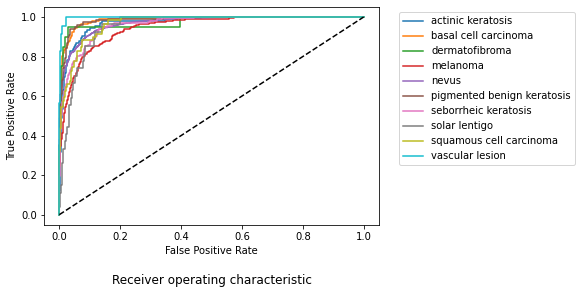

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

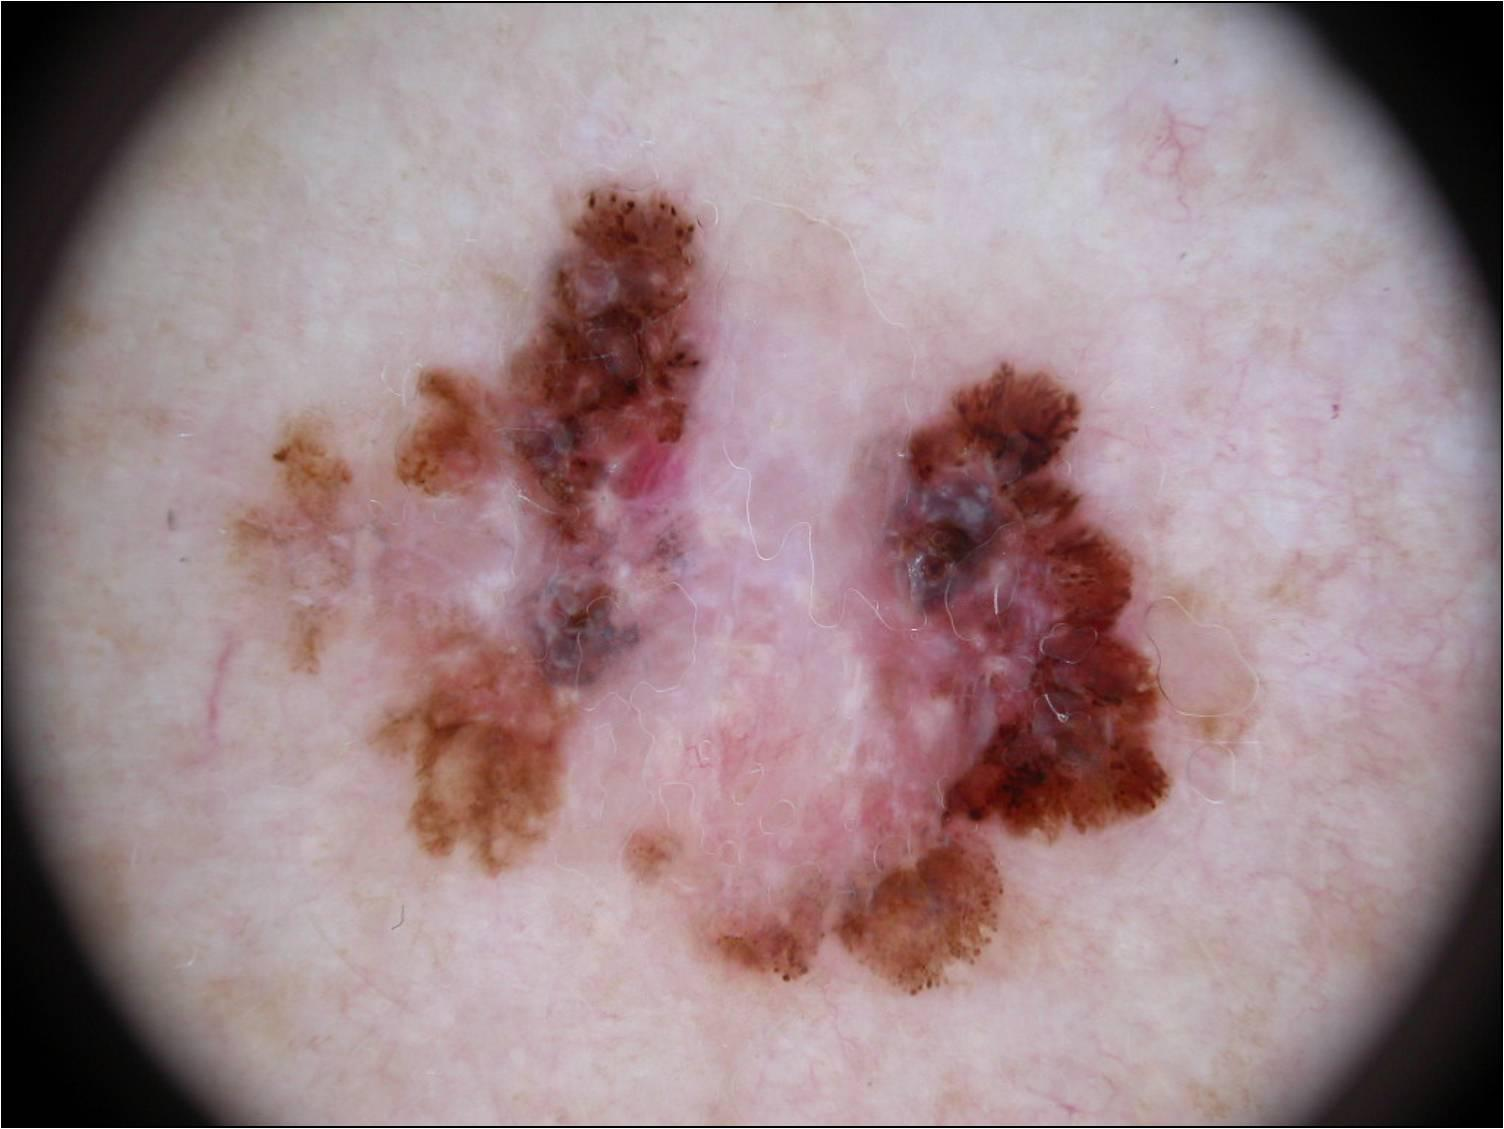

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

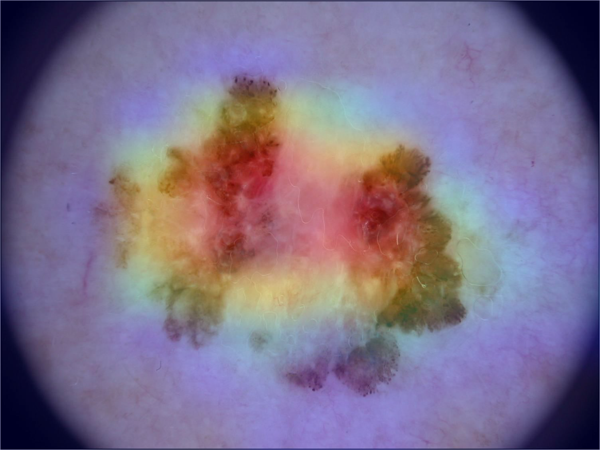

In [23]:
display_gradcam(melanoma_im_path, heatmap)